In [1]:
!pip install -r requirement.txt -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Fri_Jan__6_16:45:21_PST_2023
Cuda compilation tools, release 12.0, V12.0.140
Build cuda_12.0.r12.0/compiler.32267302_0


In [3]:
!python -c "import torch; print(torch.cuda.is_available()); print(torch.version.cuda); print(torch.cuda.get_device_name(0))"

True
11.6
NVIDIA GeForce RTX 3060 Laptop GPU


In [4]:
!python -c "from allennlp.modules.feedforward import FeedForward; print('✅ All good')"


✅ All good


In [5]:
!pip install rdkit

In [6]:
!python tokenizer.py

In [7]:
!python layers.py

In [ ]:
!python model_2.0_Reward.py
!pip install pandas

In [9]:
import pandas as pd
import numpy as np
from rdkit import Chem

# Load dataset (qm9.csv should be in the working directory)
try:
    df = pd.read_csv('qm9.csv')
except FileNotFoundError:
    print("Dataset file qm9.csv not found. Please ensure it is available.")
    df = None

if df is not None:
    print("Loaded dataset with shape:", df.shape)
    # Display first few entries
    display(df.head(5))
    
    # Extract SMILES strings for training
    smiles_list = df['smiles'].tolist()
else:
    # If dataset not found, create a small dummy dataset for demonstration
    smiles_list = ["CCO", "CCN", "N#N", "C1=CC=CC=C1", "C1CC1"]  # example molecules
    df = pd.DataFrame({'smiles': smiles_list})
    print("Using a dummy dataset of SMILES:", smiles_list)


Loaded dataset with shape: (133885, 21)


,mol_id,smiles,A,B,C,mu,alpha,homo,lumo,gap,...,zpve,u0,u298,h298,g298,cv,u0_atom,u298_atom,h298_atom,g298_atom
0,gdb_1,C,157.71180,157.709970,157.706990,0.0000,13.21,-0.3877,0.1171,0.5048,...,0.044749,-40.478930,-40.476062,-40.475117,-40.498597,6.469,-395.999595,-398.643290,-401.014647,-372.471772
1,gdb_2,N,293.60975,293.541110,191.393970,1.6256,9.46,-0.2570,0.0829,0.3399,...,0.034358,-56.525887,-56.523026,-56.522082,-56.544961,6.316,-276.861363,-278.620271,-280.399259,-259.338802
2,gdb_3,O,799.58812,437.903860,282.945450,1.8511,6.31,-0.2928,0.0687,0.3615,...,0.021375,-76.404702,-76.401867,-76.400922,-76.422349,6.002,-213.087624,-213.974294,-215.159658,-201.407171
3,gdb_4,C#C,0.00000,35.610036,35.610036,0.0000,16.28,-0.2845,0.0506,0.3351,...,0.026841,-77.308427,-77.305527,-77.304583,-77.327429,8.574,-385.501997,-387.237686,-389.016047,-365.800724
4,gdb_5,C#N,0.00000,44.593883,44.593883,2.8937,12.99,-0.3604,0.0191,0.3796,...,0.016601,-93.411888,-93.409370,-93.408425,-93.431246,6.278,-301.820534,-302.906752,-304.091489,-288.720028


In [11]:
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem

def compute_metrics(smiles_batch):
    """Compute validity, novelty, diversity, discriminator reward, and average QED for a batch of SMILES."""
    
    # Validity
    valid_flags = [Chem.MolFromSmiles(s) is not None for s in smiles_batch]
    validity = np.mean(valid_flags)
    
    # Novelty (only consider valid molecules for novelty)
    novelty = 0.0
    if np.sum(valid_flags) > 0:
        novel_flags = [(s not in train_smiles_set) for s, valid in zip(smiles_batch, valid_flags) if valid]
        novelty = np.mean(novel_flags)
    
    # Diversity (compute fingerprint-based diversity for valid molecules)
    diversity = 0.0
    valid_smiles = [s for s, v in zip(smiles_batch, valid_flags) if v]
    if len(valid_smiles) >= 2:
        fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(s), radius=2, nBits=1024) 
               for s in valid_smiles]
        sims = []
        for i in range(len(fps)):
            sims_i = DataStructs.BulkTanimotoSimilarity(fps[i], fps[i+1:])
            sims.extend(sims_i)
        if sims:
            diversity = 1 - np.mean(sims)
    
    # Discriminator reward (only for valid SMILES)
    valid_smiles_batch = [s for s, valid in zip(smiles_batch, valid_flags) if valid]
    if len(valid_smiles_batch) == 0:
        reward = 0.0
    else:
        seqs = []
        for s in valid_smiles_batch:
            try:
                seq = gan_mol.tokenizer.encode_smile(s)
                seqs.append(seq)
            except KeyError:
                continue  # Skip corrupted SMILES safely
        
        if len(seqs) == 0:
            reward = 0.0
        else:
            x_pad = torch.nn.utils.rnn.pad_sequence(seqs, batch_first=True).to(device)
            with torch.no_grad():
                disc_out = gan_mol.discriminator(x_pad)
                y_pred = disc_out['out']
                mask = disc_out['mask']
            R = (2 * y_pred - 1) * mask
            if mask.sum().item() > 0:
                reward = (R.sum() / mask.sum()).item()
            else:
                reward = 0.0

    # QED score (only for valid molecules)
    from rdkit.Chem import QED
    qed_scores = []
    for s in valid_smiles_batch:
        mol = Chem.MolFromSmiles(s)
        if mol is not None:
            qed_scores.append(QED.qed(mol))
    avg_qed = np.mean(qed_scores) if qed_scores else 0.0

    return validity, novelty, diversity, reward, avg_qed


In [12]:
max_steps = 10000  # total training steps
eval_every = 50     # evaluate every 50 steps
eval_size = 100     # generate 100 molecules for evaluation each time

# Training SMILES List
# (This should come from your training dataset)
# Example:
# smiles_list = df['smiles'].tolist()
# You must ensure `smiles_list` exists already!

train_smiles_set = set(smiles_list)  # ✅ Define train_smiles_set once

# Initialize metrics history
metrics_history = {
    'step': [],
    'validity': [],
    'novelty': [],
    'diversity': [],
    'reward': [],
    'qed': []
}


gan_mol.train()  
loader_iter = iter(train_loader)

for step in range(1, max_steps+1):
    try:
        batch = next(loader_iter)
    except StopIteration:
        loader_iter = iter(train_loader)
        batch = next(loader_iter)

    gan_mol.train_step(batch)

    if step % eval_every == 0 or step == max_steps:
        gan_mol.eval()
        gen_smiles = gan_mol.generate_n(eval_size)
        
        v, n, d, r, q = compute_metrics(gen_smiles)

        metrics_history['step'].append(step)
        metrics_history['validity'].append(v)
        metrics_history['novelty'].append(n)
        metrics_history['diversity'].append(d)
        metrics_history['reward'].append(r)
        metrics_history['qed'].append(q) 
        
        print(f"Step {step:4d}: Validity={v:.2f}, Novelty={n:.2f}, Diversity={d:.2f}, Reward={r:.2f}, QED={q:.2f}")
        gan_mol.train()


print("\nTraining complete.")

Step   50: Validity=0.01, Novelty=0.00, Diversity=0.00, Reward=-0.90, QED=0.33
Step  100: Validity=0.02, Novelty=0.00, Diversity=1.00, Reward=-0.84, QED=0.37
Step  150: Validity=0.09, Novelty=0.33, Diversity=0.81, Reward=-0.55, QED=0.37
Step  200: Validity=0.24, Novelty=0.17, Diversity=0.75, Reward=-0.94, QED=0.38
Step  250: Validity=0.19, Novelty=0.37, Diversity=0.86, Reward=-0.95, QED=0.37
Step  300: Validity=0.12, Novelty=0.42, Diversity=0.87, Reward=-0.89, QED=0.42
Step  350: Validity=0.01, Novelty=1.00, Diversity=0.00, Reward=-0.76, QED=0.33
Step  400: Validity=0.11, Novelty=0.64, Diversity=0.93, Reward=-0.86, QED=0.41
Step  450: Validity=0.15, Novelty=0.60, Diversity=0.88, Reward=-0.96, QED=0.42
Step  500: Validity=0.17, Novelty=0.59, Diversity=0.81, Reward=-0.91, QED=0.48
Step  550: Validity=0.27, Novelty=0.52, Diversity=0.76, Reward=-0.84, QED=0.48
Step  600: Validity=0.12, Novelty=0.67, Diversity=0.84, Reward=-0.87, QED=0.50
Step  650: Validity=0.09, Novelty=1.00, Diversity=0.

In [13]:
gan_mol.eval()
final_gen_smiles = gan_mol.generate_n(1000)  # generate a larger sample for final evaluation
final_validity, final_novelty, final_diversity, final_reward, final_qed = compute_metrics(final_gen_smiles)

print("\nFinal Evaluation Metrics:")
print(f"Validity:       {final_validity:.6f}")
print(f"Novelty:        {final_novelty:.6f}")
print(f"Diversity:      {final_diversity:.6f}")
print(f"Reward (Disc):  {final_reward:.6f}")
print(f"QED:            {final_qed:.6f}")



Final Evaluation Metrics:
Validity:       1.000000
Novelty:        1.000000
Diversity:      0.113545
Reward (Disc):  -0.446657
QED:            0.766120


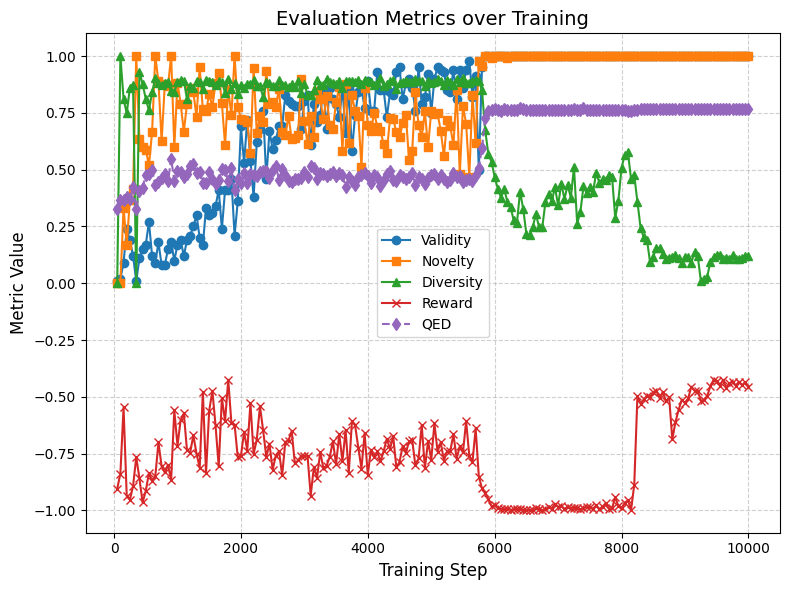

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Convert metrics history to numpy arrays
steps = np.array(metrics_history['step'])
val_hist = np.array(metrics_history['validity'])
novel_hist = np.array(metrics_history['novelty'])
div_hist = np.array(metrics_history['diversity'])
rew_hist = np.array(metrics_history['reward'])
qed_hist = np.array(metrics_history['qed'])  # ✅ New line

# Create the plot
plt.figure(figsize=(8,6))

plt.plot(steps, val_hist, label='Validity', marker='o')
plt.plot(steps, novel_hist, label='Novelty', marker='s')
plt.plot(steps, div_hist, label='Diversity', marker='^')
plt.plot(steps, rew_hist, label='Reward', marker='x')
plt.plot(steps, qed_hist, label='QED', marker='d', linestyle='--')  # ✅ Added QED line

plt.xlabel('Training Step', fontsize=12)
plt.ylabel('Metric Value', fontsize=12)
plt.title('Evaluation Metrics over Training', fontsize=14)
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


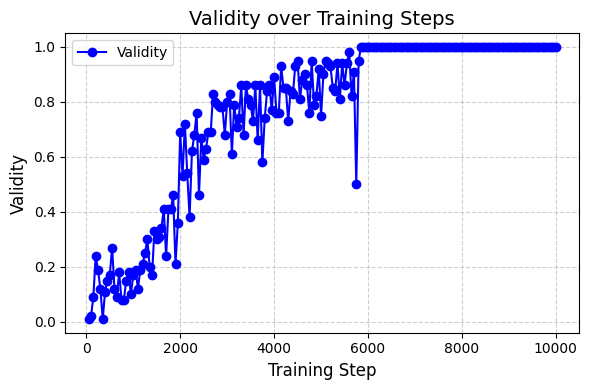

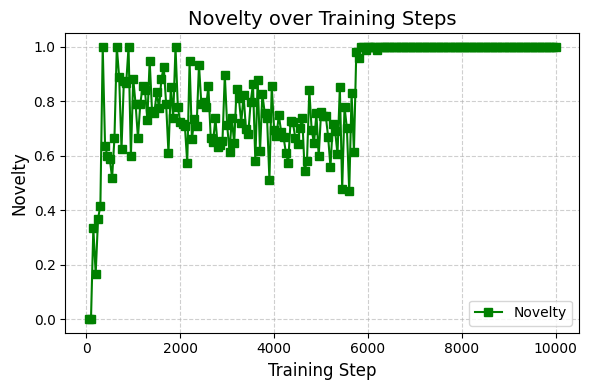

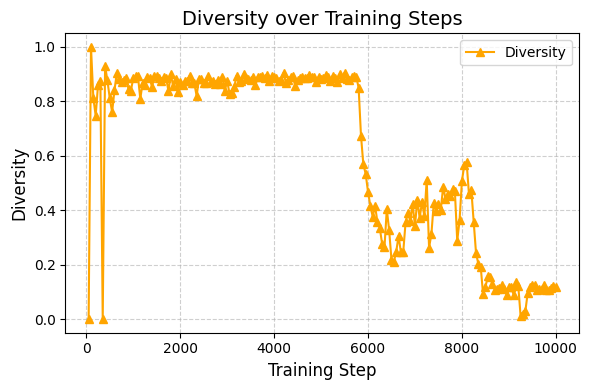

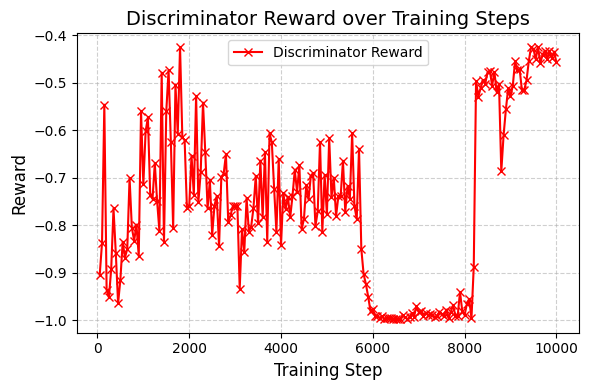

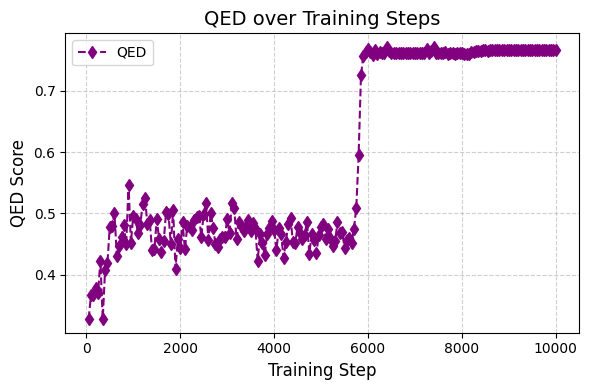

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Convert metrics history to numpy arrays
steps = np.array(metrics_history['step'])
val_hist = np.array(metrics_history['validity'])
novel_hist = np.array(metrics_history['novelty'])
div_hist = np.array(metrics_history['diversity'])
rew_hist = np.array(metrics_history['reward'])
qed_hist = np.array(metrics_history['qed'])  # ✅ Added QED

# Plot Validity
plt.figure(figsize=(6,4))
plt.plot(steps, val_hist, label='Validity', color='blue', marker='o')
plt.xlabel('Training Step', fontsize=12)
plt.ylabel('Validity', fontsize=12)
plt.title('Validity over Training Steps', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Novelty
plt.figure(figsize=(6,4))
plt.plot(steps, novel_hist, label='Novelty', color='green', marker='s')
plt.xlabel('Training Step', fontsize=12)
plt.ylabel('Novelty', fontsize=12)
plt.title('Novelty over Training Steps', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Diversity
plt.figure(figsize=(6,4))
plt.plot(steps, div_hist, label='Diversity', color='orange', marker='^')
plt.xlabel('Training Step', fontsize=12)
plt.ylabel('Diversity', fontsize=12)
plt.title('Diversity over Training Steps', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Discriminator Reward
plt.figure(figsize=(6,4))
plt.plot(steps, rew_hist, label='Discriminator Reward', color='red', marker='x')
plt.xlabel('Training Step', fontsize=12)
plt.ylabel('Reward', fontsize=12)
plt.title('Discriminator Reward over Training Steps', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# ✅ Plot QED
plt.figure(figsize=(6,4))
plt.plot(steps, qed_hist, label='QED', color='purple', marker='d', linestyle='--')
plt.xlabel('Training Step', fontsize=12)
plt.ylabel('QED Score', fontsize=12)
plt.title('QED over Training Steps', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


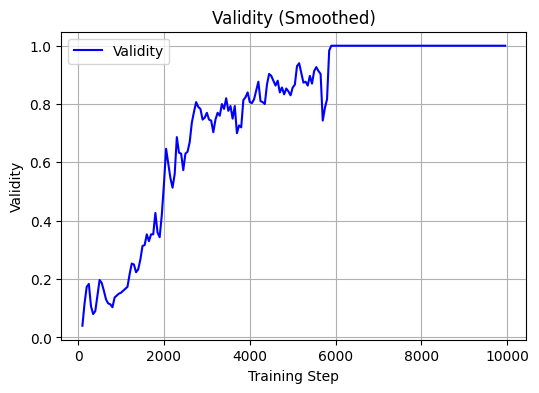

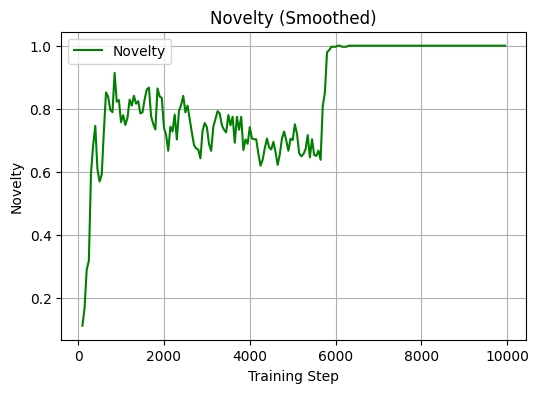

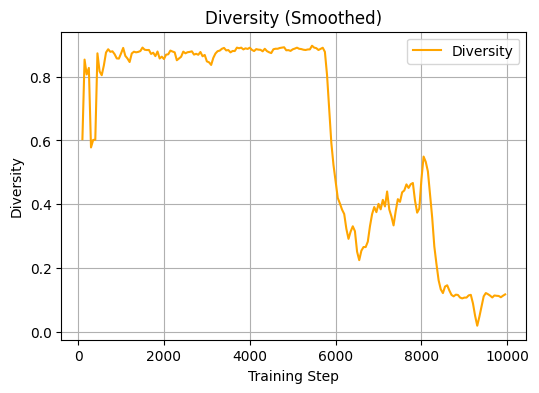

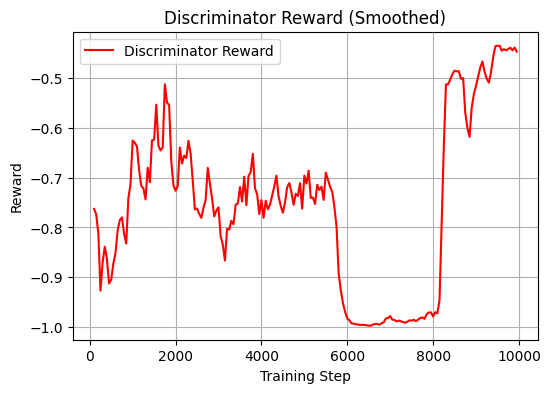

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Moving Average Function
def moving_average(x, w=3):
    return np.convolve(x, np.ones(w), 'valid') / w

# Convert metrics history to numpy arrays
steps = np.array(metrics_history['step'])
val_hist = np.array(metrics_history['validity'])
novel_hist = np.array(metrics_history['novelty'])
div_hist = np.array(metrics_history['diversity'])
rew_hist = np.array(metrics_history['reward'])

# Apply moving average smoothing
smooth_val = moving_average(val_hist, w=3)
smooth_novel = moving_average(novel_hist, w=3)
smooth_div = moving_average(div_hist, w=3)
smooth_rew = moving_average(rew_hist, w=3)

smooth_steps = steps[1:-1]  # because 3-point moving average shortens the array by 2

# Now plot the smooth curves separately
plt.figure(figsize=(6,4))
plt.plot(smooth_steps, smooth_val, label='Validity', color='blue')
plt.xlabel('Training Step')
plt.ylabel('Validity')
plt.title('Validity (Smoothed)')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(smooth_steps, smooth_novel, label='Novelty', color='green')
plt.xlabel('Training Step')
plt.ylabel('Novelty')
plt.title('Novelty (Smoothed)')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(smooth_steps, smooth_div, label='Diversity', color='orange')
plt.xlabel('Training Step')
plt.ylabel('Diversity')
plt.title('Diversity (Smoothed)')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(smooth_steps, smooth_rew, label='Discriminator Reward', color='red')
plt.xlabel('Training Step')
plt.ylabel('Reward')
plt.title('Discriminator Reward (Smoothed)')
plt.grid(True)
plt.legend()
plt.show()


In [17]:
!pip install seaborn

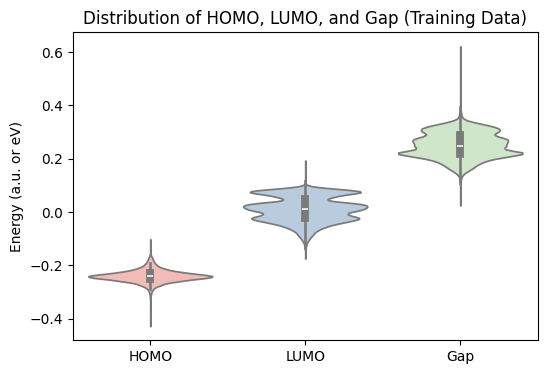

In [18]:
import seaborn as sns

# Use the training dataset properties for distribution plots
if df is not None and {'homo','lumo','gap'}.issubset(df.columns):
    props = df[['homo','lumo','gap']].copy()
    props.columns = ['HOMO','LUMO','Gap']
    plt.figure(figsize=(6,4))
    sns.violinplot(data=props, palette='Pastel1', cut=0)
    plt.title('Distribution of HOMO, LUMO, and Gap (Training Data)')
    plt.ylabel('Energy (a.u. or eV)')
    plt.show()
else:
    print("Property columns not available for distribution plot.")


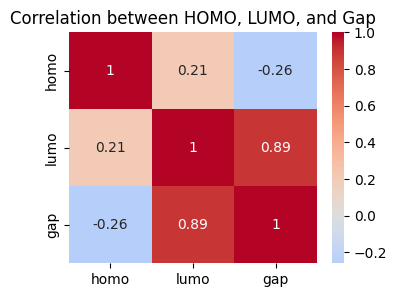

In [19]:
if df is not None and {'homo','lumo','gap'}.issubset(df.columns):
    corr_matrix = df[['homo','lumo','gap']].corr()
    plt.figure(figsize=(4,3))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation between HOMO, LUMO, and Gap')
    plt.show()


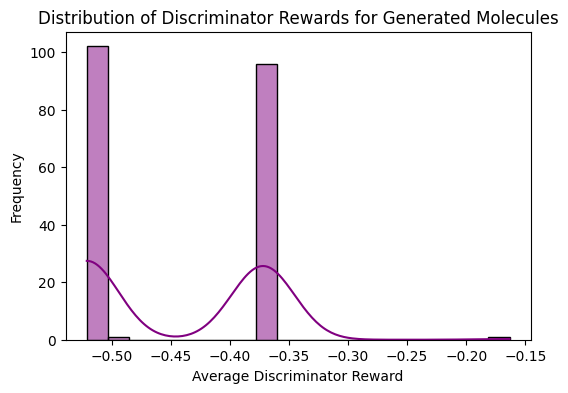

In [20]:
# Compute average reward per molecule for a batch of generated molecules
gen_sample = gan_mol.generate_n(200)  # generate 200 molecules for analysis
# Tokenize and get discriminator outputs
seqs = [gan_mol.tokenizer.encode_smile(s) for s in gen_sample]
x_pad = torch.nn.utils.rnn.pad_sequence(seqs, batch_first=True).to(device)
with torch.no_grad():
    result = gan_mol.discriminator(x_pad)
    y_pred, mask = result['out'], result['mask']
R = (2 * y_pred - 1) * mask  # reward for each token
# Calculate average reward per molecule (mean over each sequence's tokens)
seq_lengths = mask.sum(axis=1)
avg_rewards = []
for i in range(R.size(0)):
    if seq_lengths[i] > 0:
        avg_rewards.append((R[i][:int(seq_lengths[i])].mean().item()))
avg_rewards = np.array(avg_rewards)

plt.figure(figsize=(6,4))
sns.histplot(avg_rewards, kde=True, color='purple', bins=20)
plt.xlabel('Average Discriminator Reward')
plt.ylabel('Frequency')
plt.title('Distribution of Discriminator Rewards for Generated Molecules')
plt.show()


In [21]:
# After training
# generate Smiles molecules
smiles_list = gan_mol.generate_n(1000)

# convert with rdkit
mol_list = [Chem.MolFromSmiles(m) for m in smiles_list]

# draw
Chem.Draw.MolsToGridImage(mol_list, molsPerRow=4, subImgSize=(250, 250), maxMols=100)

# ➡️ Save the generated SMILES into a text file
with open("generated_smiles.txt", "w") as f:
    for sm in smiles_list:
        f.write(sm + "\n")

print("Generated SMILES saved to 'generated_smiles.txt'")


/home/satya/miniconda3/envs/allennlp_env/lib/python3.8/site-packages/rdkit/Chem/Draw/IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 100. Change the maxMols value to display more.
  warnings.warn(


Generated SMILES saved to 'generated_smiles.txt'


In [22]:
import pandas as pd

# Load your original training dataset
df_train = pd.read_csv('qm9.csv')

# Load the generated SMILES
with open('generated_smiles.txt', 'r') as f:
    generated_smiles = [line.strip() for line in f.readlines()]

# Make a set for faster lookup
train_smiles_set = set(df_train['smiles'].values)

# Now check
old_molecules = [sm for sm in generated_smiles if sm in train_smiles_set]
new_molecules = [sm for sm in generated_smiles if sm not in train_smiles_set]

# Print results
print(f"Total Generated Molecules: {len(generated_smiles)}")
print(f"Old Molecules (already existed in training data): {len(old_molecules)}")
print(f"New Molecules (novel, not in training data): {len(new_molecules)}")

# (Optional) Save the lists separately if needed
with open("old_molecules.txt", "w") as f_old:
    for sm in old_molecules:
        f_old.write(sm + "\n")

with open("new_molecules.txt", "w") as f_new:
    for sm in new_molecules:
        f_new.write(sm + "\n")


Total Generated Molecules: 1000
Old Molecules (already existed in training data): 0
New Molecules (novel, not in training data): 1000


In [23]:
from rdkit import Chem
from rdkit.Chem import QED

# Suppose smiles_list is your generated molecules
smiles_list = gan_mol.generate_n(1000)

# Convert SMILES to molecules
mol_list = [Chem.MolFromSmiles(sm) for sm in smiles_list]

# Calculate QED scores
qed_scores = []
for mol in mol_list:
    if mol is not None:
        qed_scores.append(QED.qed(mol))
    else:
        qed_scores.append(None)  # if molecule parsing failed

# Now qed_scores contains QED value for each generated molecule

# Let's see average QED for your generated molecules
qed_valid = [q for q in qed_scores if q is not None]  # remove invalids
if qed_valid:
    avg_qed = sum(qed_valid) / len(qed_valid)
    print(f"Average QED score of generated molecules: {avg_qed:.4f}")
else:
    print("No valid molecules to compute QED.")


Average QED score of generated molecules: 0.7661


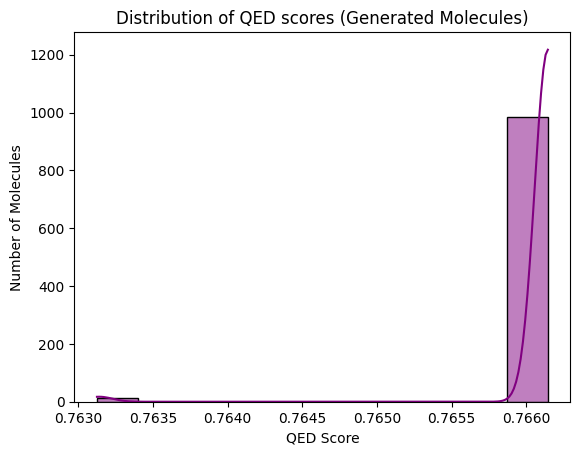

Average QED score: 0.7661 ± 0.0004


In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(qed_valid, kde=True, color='purple')
plt.title("Distribution of QED scores (Generated Molecules)")
plt.xlabel("QED Score")
plt.ylabel("Number of Molecules")
plt.show()


import numpy as np

qed_valid = np.array([q for q in qed_scores if q is not None])
if qed_valid.size > 0:
    avg_qed = qed_valid.mean()
    std_qed = qed_valid.std()
    print(f"Average QED score: {avg_qed:.4f} ± {std_qed:.4f}")


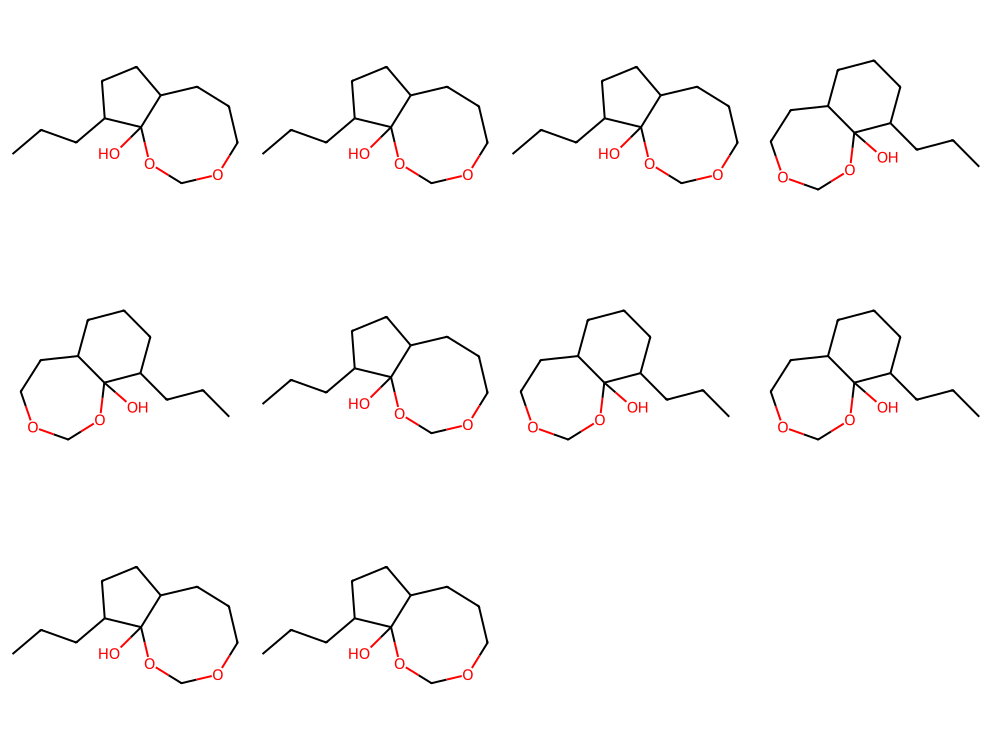

In [25]:
# After training
# generate Smiles molecules
smiles_list = gan_mol.generate_n(10)

# convert with rdkit
mol_list = [Chem.MolFromSmiles(m) for m in smiles_list]

# draw
Chem.Draw.MolsToGridImage(mol_list, molsPerRow=4, subImgSize=(250, 250), maxMols=100)